In [ ]:
# will need to look at data in beats and maybe better align / remove

In [1]:
import pandas as pd
import os
from datetime import datetime
import sqlite3
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence 
from sklearn.metrics import classification_report


%matplotlib inline

In [487]:
nm = pd.read_pickle("data/all_calls17_uof_df.pkl")

# need to:
# make a y and make categories numeric(?)
# drop CAD and Event and Force
# make dummie columns
# cahnge month and day to integers


In [496]:
fl = nm.groupby("Force_Level")
fbvc = fl.Beat.value_counts()
fbvc[0]

Beat
E2       55112
M3       54397
K3       46000
N3       45079
D2       41866
M2       41780
K2       41673
K1       36435
M1       35923
O1       35664
W1       33948
Q3       31542
R2       31465
D3       31364
D1       31132
U2       30681
E1       30534
U1       28619
B1       28217
R3       28174
S2       27942
F1       27040
F2       26839
S1       26275
W2       26183
E3       26098
B2       26057
N2       25961
B3       25834
U3       25408
         ...  
ODD         16
TAC2        16
LS          15
QS          11
CD           9
H3           8
CMD          6
CCD          5
SD           5
SPVD         5
TQ           5
TAC3         4
WD           4
CMD2         2
DSPVD        2
ED           2
HBR          2
XDD          2
1            1
DBB          1
DBD          1
DCC          1
DCD          1
DDB          1
H1           1
H2           1
MTD          1
ND           1
T            1
TAC9         1
Name: Beat, Length: 116, dtype: int64

In [ ]:
nm.Precinct.replace({'W': "WEST", "N": "NORTH", "E": "EAST", "S": "SOUTH"})

In [235]:
# make a copy to alter for the model in case I want to look back at this
nm2 = nm.copy(deep=True)

In [236]:
# drop columns and make time ints
nm.drop([ "CAD_Event_Number", "Event_Clearance_Description"], axis=1, inplace=True)
nm["month"] = nm["month"].astype(int)
nm["day"] = nm["day"].astype(int)

In [237]:
# better categories in Initial Call Type

init = nm["Initial_Call_Type"]
to_drop = init[init.str.startswith("-ASSIGNED DUTY")]


s = nm["Initial_Call_Type"].str.replace(" - .*", "", regex=True)
nm["Initial_Call_Type"] = s

In [238]:
#drop = ["ASSIST PUBLIC", ]  -DOWN TIME - OUT OF SERVICE  

In [239]:
# function for later to categorize ICT column

def initial_call_type_cats(value):    
    if "MVC" in value:
        return "Motor Vehicle Collision"
    elif value.startswith("FRAUD"):
        return "Fraud"
    elif "SUSPICIOUS STOP" in value:
        return "Police Initiated Stop"
    elif "SUSPICIOUS" in value:
        return "Suspicious person, vehicle, incident"
    elif "TRAFFIC STOP" in value:
        return "Police Initiated Stop"
    elif "ROAD RAGE" in value:
        return "Road Rage"
    elif "MOVING VIOLATION" in value:
        return "Moving Violation"
    elif "TRAF" in value:
        return "Moving Violation"
    elif "BLOCKING ROADWAY" in value:
        return "Parking Violation"
    elif "TRAFFIC - ASSIST" in value:
        return "Assist Motorist"
    elif "DISTURBANCE" in value:
        return "Disturbance"
    elif "NOISE" in value:
        return "Disturbance"
    elif "OFF DUTY EMPLOYMENT" in value:
        return "Police Initiated - Off Duty"
    elif "NUISANCE" in value:
        return "Nuisance"
    elif "NARCOTICS" in value:
        return "Narcotics"
    elif "SEX IN PUBLIC" in value:
        return "Lewd Conduct"
    elif "VIOLATION OF COURT ORDER (NON DV)" in value:
        return "Violation of Court Order (Not Domestic Violence)"
    elif "NOT DV" in value:
        return "Alarm"
    elif "SHOTS" in value:
        return "Shots heard"
    elif "DV" in value:
        return "Domestic Violence"
    elif "ASSAULTS" in value:
        return "Assault"
    elif "WEAPN" in value:
        return "Deadly Weapon - No Assault"
    elif "ASLT" in value:
        return "Assault"
    elif "FIGHT" in value:
        return "Assault"
    elif "THEFT" in value:
        return "Robbery"
    elif "PREMISE CHECK" in value:
        return "Police Initiated"
    elif "DIRECTED PATROL ACTIVITY" in value:
        return "Assigned Duty"
    elif "UNUSUAL OCCURRENCES - EARTHQUAKE, RIOT, ETC)" in value:
        return "Disturbance"
    elif "PARKING" in value:
        return "Parking Violation"
    elif "ALARM"in value:
        return "Alarm"
    elif "BURG" in value:
        return "Robbery"
    elif "WATER FLOODS" in value:
        return "Nuisance"
    elif "TREES DOWN" in value:
        return "Nuisance"
    elif "HAZ" in value:
        return "Hazard - immediate threat"
    elif "TRESPASS" in value:
        return "Trespass"
    elif "FOLLOW" in value:
        return "Follow up"
    elif "WELFARE" in value:
        return "Welfare Check"
    elif "SERVICE" in value:
        return "Assisting other agencies"
    elif "SFD" in value:
        return "Assisting other agencies"
    elif "SUICIDE" in value:
        return "Suicidal person or attempts"
    elif "LIQUOR" in value:
        return "Liquor Violations"
    elif "AUTO" in value:
        return "Auto Recovery"
    elif "DAMAGE" in value:
        return "Damaged Property"
    elif "DAMG" in value:
        return "Damaged Property"
    elif "PROPERTY" in value:
        return "Property lost or found"
    elif "FOLLOW UP" in value:
        return "Follow up"
    elif "PERSON IN BEHAVIORAL/EMOTIONAL CRISIS" in value:
        return "Behavioral / Emotional Crisis"
    elif "DOWN - CHECK" in value:
        return "Check for Person Down"
    elif "SICK" in value:
        return "-"
    elif "--PERSON" in value:
        return "Missing Person"
    elif "INJURED" in value:
        return "Injuries from Industrial Accidents"
    elif "PICKUP" in value:
        return "Pickup Person"
    elif "BOMB" in value:
        return "Threats"
    elif "THREAT" in value:
        return "Threats"
    elif "RAPE" in value:
        return "Rape"
    elif "ROBBERY" in value:
        return "Robbery"
    elif "KIDNAPPING" in value:
        return "Missing Person"
    elif "MISSING" in value:
        return "Missing Person"
    elif "PROWLER" in value:
        return "Suspicious person, vehicle, incident"
    elif "PANHANDLING" in value:
        return "Aggressive Panhandling"
    elif "RUNAWAY" in value:
        return "Missing Person"
    elif "ASSIGNED DUTY" in value:
        return "Assigned Duty"
    elif "KIDNAPPNG" in value:
        return "Missing Person"
    elif "LEWD" in value:
        return "Lewd Conduct"
    elif "OVERDOSE" in value:
        return "Overdose - Drug Related Casualty"
    elif "PREDICTIVE POLICING" in value:
        return "Predictive Policing"
    elif "DETOX" in value:
        return "Request for Detox"
    elif "REQUEST" in value:
        return "Request to Watch / Ensure Peace"
    elif "CHILD" in value:
        return "Child Abuse"
    elif "PURSE" in value:
        return "Robbery"
    elif "PEACE" in value:
        return "Request to Watch / Ensure Peace"
    elif "DEAD" in value:
        return "Casualty"
    elif "GAMBLING" in value:
        return "Gambling"
    elif "ANIMAL" in value:
        return "Animal - Dangerous / Bite"
    elif "ESCAPE" in value:
        return "-"
    elif "PARKS" in value:
        return "Parks Violations"
    elif "PROSTITUTION" in value:
        return "Prostitution"
    elif "Pornography" in value:
        return "Lewd Conduct"
    elif "DUI" in value:
        return "DUI - Driving While Under the Influence"
    elif "SEX OFFENDER" in value:
        return "-"
    elif "SEX" in value:
        return "-"
    elif "SLEEP" in value:
        return "Sleeper Aboard Public Transit"
    elif "HARASSMENT" in value:
        return "Harassment"
    elif "EXPLOSION" in value:
        return "Explosion / Arson"
    elif "ARSON" in value:
        return "Explosion / Arson"
    elif "PREPLANNED" in value:
        return "Assigned Duty"
    elif "ASSIGNMENT" in value:
        return "Assigned Duty"
    elif "SHOPLIFT" in value:
        return "Robbery"
    elif "ELUDING" in value:
        return "Eluding Police"
    elif "LITTERING" in value:
        return "Illegal Dumping"
    elif "DUMPING" in value:
        return "Illegal Dumping"
    elif "BURN" in value:
        return "Explosion / Arson"
    else:
        return "-"
    
    
    

In [240]:
# calling above function to make list to make column
new_col = []
for idx, row in nm.iterrows():
    value = row.Initial_Call_Type
    new_col.append(initial_call_type_cats(value))

In [241]:
nm["cat_ICT"] = new_col


In [242]:

# Get nums of indexes for which column has '-'
indexnums = nm[ nm['cat_ICT'] == '-'].index
nm.drop(indexnums,  inplace=True)

In [243]:
# make copy so you don't repeat this ... AGAIN

nm_cat_ICT = nm.copy(deep=True)

In [245]:
#nm2["cat_ICT"] = new_col
'''
indexnums = nm2[ nm2['cat_ICT'] == '-'].index
nm2.drop(indexnums,  inplace=True)

nmvc2 = nm2.groupby("cat_ICT")
lst = nmvc2.Force_Level.value_counts()
nmvc3 = nm2.groupby("Force_Level")
lst2 = nmvc3.cat_ICT.value_counts()
lst2["Level 1 - Use of Force"]
#lst2.iloc[[0,:]]'''

'\nindexnums = nm2[ nm2[\'cat_ICT\'] == \'-\'].index\nnm2.drop(indexnums,  inplace=True)\n\nnmvc2 = nm2.groupby("cat_ICT")\nlst = nmvc2.Force_Level.value_counts()\nnmvc3 = nm2.groupby("Force_Level")\nlst2 = nmvc3.cat_ICT.value_counts()\nlst2["Level 1 - Use of Force"]\n#lst2.iloc[[0,:]]'

In [246]:

nmvc = nm["cat_ICT"].value_counts()
len(nmvc.index)


46

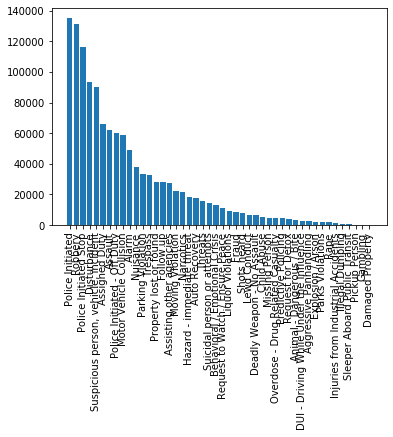

In [247]:
plt.bar(nmvc.index, list(nmvc))
plt.xticks(rotation="vertical");

In [248]:
nm.drop("Initial_Call_Type", axis=1, inplace=True)

In [249]:
# get dummies for string valued columns
nm = pd.get_dummies(data = nm, 
                     columns=["Precinct", "Sector", "Beat", "Subject_Gender", "Subject_Race", "Call_Type", 
                               "cat_ICT"], 
                     prefix=["P",  "S", "B", "SG", "SR","CT", "ICT"])

In [250]:
# dropping the "-" Precinct and Sector columns - they aren't useful for interpretation

nm.drop(["S_-", "P_-"], axis=1, inplace=True)

In [251]:
# dropping column

nm.drop(['SG_-', 'SR_-'], axis=1, inplace=True)
nm.Force_Level.replace({"Level 1 - Use of Force":1,"Level 2 - Use of Force":2,"Level 3 - OIS":4, "Level 3 - Use of Force": 3 }, inplace=True)


In [273]:
# undersampling / oversampling
four = nm[nm["Force_Level"] == 4]
three = nm[nm["Force_Level"] == 3]
two = nm[nm["Force_Level"] == 2]
one = nm[nm["Force_Level"] == 1]
zero = nm[nm["Force_Level"] == 0]

In [274]:
len(four), len(three), len(two), len(one), len(zero)

(63, 112, 1840, 5448, 1256325)

In [382]:
#nm["Weights"] = np.where(nm['Force_Level'] <= 4, .1, .9)

nm["Weights"] = nm["Force_Level"]
nm["Weights"].replace({4:.5, 3:.3, 2:.1105, 1:.08, 0:.0005}, inplace=True)

In [385]:
sample1 = nm.sample(n=600000, weights='Weights', random_state=659, replace=True)

In [454]:
len(sample1[sample1.Force_Level == 4]), len(sample1[sample1.Force_Level == 3]), len(sample1[sample1.Force_Level == 2]), len(sample1[sample1.Force_Level == 1]), len(sample1[sample1.Force_Level == 0])

sample4 = four.sample(n=6000, random_state=659, replace=True)
sample3 = three.sample(n=6000, random_state=659, replace=True)
sample2 = two.sample(n=6000, random_state=659, replace=True)
sample1 = one.sample(n=6000, random_state=659, replace=True)
sample0 = zero.sample(n=6000, random_state=659, replace=True)




In [465]:
sampleall = pd.concat([sample4,sample3, sample2, sample1, sample0])

In [466]:
sampleall.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 126764 to 3684563
Columns: 229 entries, Force_Level to ICT_Trespass
dtypes: int64(5), uint8(224)
memory usage: 7.8+ MB


In [467]:
list(sampleall.columns)

['Force_Level',
 'month',
 'day',
 'day_of_week',
 'hour',
 'P_E',
 'P_EAST',
 'P_N',
 'P_NORTH',
 'P_S',
 'P_SOUTH',
 'P_SOUTHWEST',
 'P_SW',
 'P_UNKNOWN',
 'P_W',
 'P_WEST',
 'P_X',
 'S_99',
 'S_B',
 'S_BOY',
 'S_C',
 'S_CHARLIE',
 'S_D',
 'S_DAVID',
 'S_E',
 'S_EDWARD',
 'S_F',
 'S_FRANK',
 'S_G',
 'S_GEORGE',
 'S_J',
 'S_JOHN',
 'S_K',
 'S_KING',
 'S_L',
 'S_LINCOLN',
 'S_M',
 'S_MARY',
 'S_N',
 'S_NORA',
 'S_O',
 'S_OCEAN',
 'S_Q',
 'S_QUEEN',
 'S_R',
 'S_ROBERT',
 'S_S',
 'S_SAM',
 'S_U',
 'S_UNION',
 'S_W',
 'S_WILLIAM',
 'B_1',
 'B_99',
 'B_B1',
 'B_B2',
 'B_B3',
 'B_BS',
 'B_C1',
 'B_C2',
 'B_C3',
 'B_CCD',
 'B_CD',
 'B_CDD',
 'B_CMD',
 'B_CMD2',
 'B_COMM',
 'B_CS',
 'B_CTY',
 'B_D1',
 'B_D2',
 'B_D3',
 'B_DBB',
 'B_DBD',
 'B_DCC',
 'B_DET',
 'B_DS',
 'B_DSPVD',
 'B_E',
 'B_E1',
 'B_E2',
 'B_E3',
 'B_ED',
 'B_EP',
 'B_ES',
 'B_F1',
 'B_F2',
 'B_F3',
 'B_FS',
 'B_G1',
 'B_G2',
 'B_G3',
 'B_GS',
 'B_H1',
 'B_H3',
 'B_HBR',
 'B_HS',
 'B_INV',
 'B_J1',
 'B_J2',
 'B_J3',
 'B_JS',
 

In [468]:
sampleall["P_NORTH"] = sampleall["P_NORTH"] + sampleall["P_N"]
sampleall["P_SOUTH"] = sampleall["P_SOUTH"] + sampleall["P_S"]
sampleall["P_WEST"] = sampleall["P_WEST"] + sampleall["P_W"]
sampleall["P_EAST"] = sampleall["P_EAST"] + sampleall["P_E"]
sampleall["P_SOUTHWEST"] = sampleall["P_SOUTHWEST"] + sampleall["P_SW"]
sampleall.drop(["P_X","S_99","ICT_Police Initiated","ICT_Assigned Duty","ICT_Parks Violations", 'CT_FK ERROR', 
                'P_UNKNOWN','SR_Not Specified', 'P_N', "P_S", "P_W", "P_E", "B_1", "B_99", "B_CCD","B_CD", "B_CDD",
               "B_CMD", "B_CMD2", "B_COMM", "B_CS","B_CTY", "B_DBB" "B_DBD", "B_DCC", "B_DET", "B_DS", "B_DSPVD",
               "B_HBR", "B_HS", "B_INV", "B_LAPT", "B_MTD", "B_N", "B_ODD", "B_OS", "B_S", "B_SCTR1", "B_SD", "B_SP",
               "B_SPVD", "B_SPVDD", "B_SS", "B_SWT", "B_TAC2", "B_TAC3", "B_TQ", "B_TRF", "B_W", "B_US", "B_WD", 
               "B_WP", ""], axis=1, inplace=True)

sampleall["S_BOY"] = sampleall["S_BOY"] + sampleall["S_B"]
sampleall["S_CHARLIE"] = sampleall["S_CHARLIE"] + sampleall["S_C"]
sampleall["S_DAVID"] = sampleall["S_DAVID"] + sampleall["S_D"]
sampleall["S_EDWARD"] = sampleall["S_EDWARD"] + sampleall["S_E"]
sampleall["S_FRANK"] = sampleall["S_FRANK"] + sampleall["S_F"]
sampleall["S_GEORGE"] = sampleall["S_GEORGE"] + sampleall["S_G"]

sampleall["S_JOHN"] = sampleall["S_JOHN"] + sampleall["S_J"]
sampleall["S_KING"] = sampleall["S_KING"] + sampleall["S_K"]
sampleall["S_LINCOLN"] = sampleall["S_LINCOLN"] + sampleall["S_L"]
sampleall["S_MARY"] = sampleall["S_MARY"] + sampleall["S_M"]
sampleall["S_NORA"] = sampleall["S_NORA"] + sampleall["S_N"]
sampleall["S_OCEAN"] = sampleall["S_OCEAN"] + sampleall["S_O"]

sampleall["S_QUEEN"] = sampleall["S_QUEEN"] + sampleall["S_Q"]
sampleall["S_ROBERT"] = sampleall["S_ROBERT"] + sampleall["S_R"]
sampleall["S_SAM"] = sampleall["S_SAM"] + sampleall["S_S"]
sampleall["S_UNION"] = sampleall["S_UNION"] + sampleall["S_U"]
sampleall["S_WILLIAM"] = sampleall["S_WILLIAM"] + sampleall["S_W"]

sampleall.drop(["S_W", "S_U","S_S",  "S_R", "S_Q", "S_O","S_N", "S_M", "S_L","S_K", "S_J", "S_G", "S_F",
               "S_E","S_D", "S_C", "S_B" ], axis=1, inplace=True)



In [472]:
X = sampleall.drop("Force_Level", axis=1)
y = sampleall.Force_Level
cols = X.columns
len(cols)

199

In [ ]:
# two minutes~

X_scaled = StandardScaler().fit_transform(nm)

In [473]:
# will need to change nm2 to X_scaled if we use this later - X_scaled hung and never finished (~10minutes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=659)

In [474]:
# create RFC model - change all but random_state after we time this one

clf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=659, oob_score=True)



In [475]:
# fit the model

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=659, verbose=0,
                       warm_start=False)

In [476]:
# save nm and y
'''
import dill as pickle

#nm.to_pickle("data/nm_cat_ICT.pkl")
#y.to_pickle("data/y.pkl")
#X2.to_pickle("data/X2_weighted.pkl")
with open('X2_weighted.pkl', 'wb') as my_pickle:
        pickle.dump(clf, my_pickle)'''

In [477]:
# check the feature importances and col_name list match first

len(clf.feature_importances_), len(cols)

(199, 199)

In [478]:
# most important features in predictions of this model

indices = np.argsort(clf.feature_importances_)
big = indices[-1:-10:-1]

list(cols[big])

['SG_Male',
 'hour',
 'B_S2',
 'month',
 'day',
 'day_of_week',
 'ICT_Shots heard',
 'SR_Black or African American',
 'SR_White']

In [479]:
# least important features
little = indices[:10]
cols[little]


Index(['B_TRF', 'B_ED', 'CT_SCHEDULED EVENT (RECURRING)', 'CT_TEXT MESSAGE',
       'ICT_Aggressive Panhandling', 'B_E', 'B_DSPVD', 'B_DS', 'B_EP',
       'B_DET'],
      dtype='object')

In [480]:
clf.oob_score_ # accuracy of training set

0.69175

In [481]:
# predicted classes

yhat = clf.predict(X_test)

In [482]:
sum(yhat == y_test) / len(yhat) # accuracy of testing set

0.7018333333333333

In [483]:
# sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)
print(classification_report(y_test, yhat))


              precision    recall  f1-score   support

           0       0.81      1.00      0.90      1219
           1       0.61      0.32      0.42      1217
           2       0.45      0.62      0.52      1175
           3       0.74      0.71      0.73      1196
           4       0.92      0.86      0.89      1193

    accuracy                           0.70      6000
   macro avg       0.71      0.70      0.69      6000
weighted avg       0.71      0.70      0.69      6000



In [420]:
# predict probabilities - what do you want threshold to be?

pp = clf.predict_proba(X_test)

In [421]:
clf.classes_

array([0, 1, 2, 3, 4])

In [422]:
# some rows' probabilities of being in each class:

for p in pp[:10]:
    print(f"Pr of no force is: {p[0]}, Pr of Force 1 is: {p[1]}, Pr of Force 2: {p[2]}, Pr of Force 3: {p[3]}, & Pr of Officer Involved Shooting: {p[4]}")
          
          

Pr of no force is: 0.09460382594944722, Pr of Force 1 is: 0.18393732368776244, Pr of Force 2: 0.2232583165727791, Pr of Force 3: 0.41359787806124904, & Pr of Officer Involved Shooting: 0.08460265572876235
Pr of no force is: 0.10181402557098787, Pr of Force 1 is: 0.24662530751237377, Pr of Force 2: 0.2806782173375557, Pr of Force 3: 0.22762556336114043, & Pr of Officer Involved Shooting: 0.14325688621794253
Pr of no force is: 0.10181291383141064, Pr of Force 1 is: 0.2432651429968557, Pr of Force 2: 0.21360505839239058, Pr of Force 3: 0.19088206952459935, & Pr of Officer Involved Shooting: 0.25043481525474376
Pr of no force is: 0.5379741670327067, Pr of Force 1 is: 0.1370291190920692, Pr of Force 2: 0.12273219753974489, Pr of Force 3: 0.11256147111466447, & Pr of Officer Involved Shooting: 0.08970304522081478
Pr of no force is: 0.09521446745497208, Pr of Force 1 is: 0.24541732283799594, Pr of Force 2: 0.288556108485143, Pr of Force 3: 0.2599489898901603, & Pr of Officer Involved Shooting

In [ ]:
len(y_test)

In [ ]:
type(y_test)

In [ ]:
y_test[y_test == 4]

In [ ]:
type(yhat)

In [ ]:
len(yhat[yhat == 4])

In [ ]:
yhat[50706]

In [ ]:
# visualization - you can plot the abundance/frequency of each selected feature within each group as a bar plot. 
# I assume visually the top feature will be more abundant in one group comparing with the other groups.

four = y_test[y_test == 4]
four, four.index

In [ ]:
fourX = X_test.iloc[[50706, 220355, 156571, 60263, 6215, 156570, 102803, 50750, 220432,
        50774],:]
fourX


In [ ]:
fournm = nm2.iloc[50706,:]
fournm

four_index = [50706, 220355, 156571, 60263, 6215, 156570, 102803, 50750, 220432,
        50774]

nm2[nm2.index.isin(four_index)]

In [ ]:
fournm.info()